In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# Importing Dataset
df = pd.read_csv('JetRail_Train.csv')

In [3]:
# Printing Head
df.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [4]:
# Printing Tail
df.tail()

,ID,Datetime,Count
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580
18287,18287,25-09-2014 23:00,534


In [5]:
df.loc[df['ID'] == 11856]

,ID,Datetime,Count
11856,11856,01-01-2014 00:00,196


## Subsetting Dataset from Aug 2012 - Dec 2013
## Creating Test and Train set for modeling
## Aug 2012 - Oct 2013 ---> Train Set
## Nov 2013 - Dec 2013 ---> Test Set
## Aggregating the dataset at daily basis

In [28]:
# Subsetting Dataset from Aug 2012 - Dec 2013
df = pd.read_csv('JetRail_Train.csv', nrows = 11856)

In [29]:
# Creating Train and Test Set
#Index 10392 marks the end of October 2013]
train = df.loc[:10392]
test = df.loc[10392:]

In [30]:
# Aggregating the dataset at daily level
df.index = pd.to_datetime(df.Datetime, format = '%d-%m-%Y %H:%M')

In [31]:
df = df.resample('D').mean()

In [32]:
train.index = pd.to_datetime(train.Datetime, format = '%d-%m-%Y %H:%M')
train = train.resample('D').mean()

In [33]:
test.index = pd.to_datetime(test.Datetime, format = '%d-%m-%Y %H:%M')
test = test.resample('D').mean()

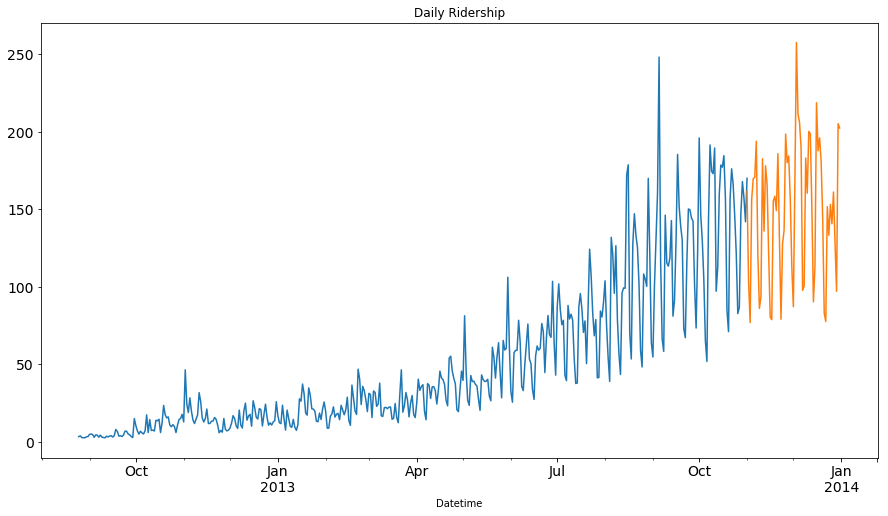

In [36]:
# Plotting Data
train.Count.plot(figsize=(15,8), title='Daily Ridership', fontsize=14)
test.Count.plot(figsize=(15,8), title='Daily Ridership', fontsize=14)

In [37]:
# Installing Statsmodels
from statsmodels.tsa.api import ExponentialSmoothing

## Method 1 - Naive Method

A forecasting technique which assumes that the next expected point is equal to the last observed point is called Naive Method.

Text(0.5, 1.0, 'Naive Forecast')

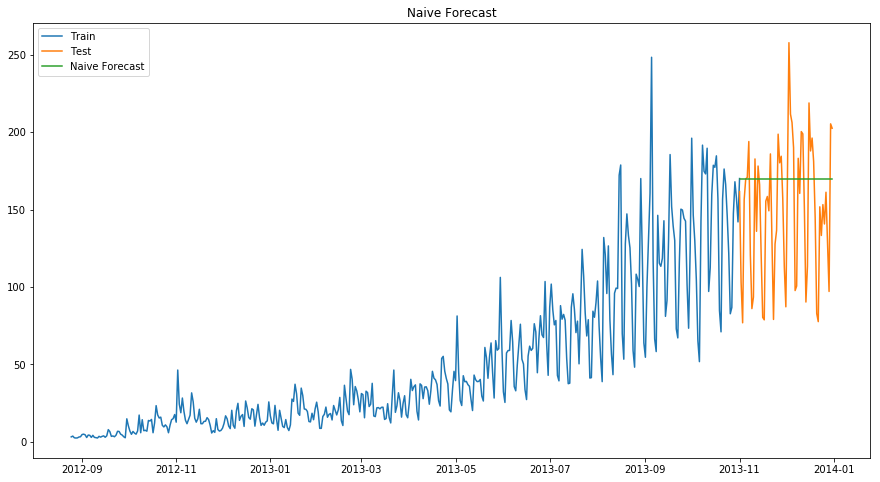

In [71]:
dd = np.asarray(train.Count)
len(dd)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(15,8))
plt.plot(train.index, train['Count'], label = 'Train')
plt.plot(test.index, test['Count'], label = 'Test')
plt.plot(y_hat.index, y_hat['naive'], label = 'Naive Forecast')
plt.legend(loc='best')
plt.title('Naive Forecast')

In [72]:
# We'll now calculate RMSE to check accuracy of Naive Method on our test dataset
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test.Count, y_hat['naive']))
print(rmse)

47.9821849529567


We can infer from the RMSE value and the graph above, that Naive method isn’t suited for datasets with high variability. It is best suited for stable datasets.

## Method 2 - Simple Average

Many a times we are provided with a dataset, which varies by a small margin throughout it’s time period, but the average at each time period remains constant. In such a case we can forecast the price of the next day somewhere similar to the average of all the past days.

Such forecasting technique which forecasts the expected value equal to the average of all previously observed points is called Simple Average technique.

Text(0.5, 1.0, 'Simple Average Forecast')

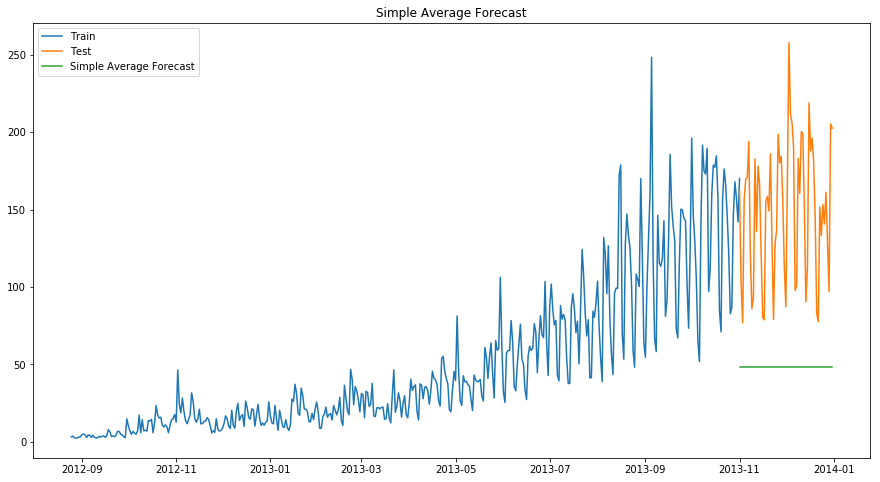

In [61]:
y_hat_avg = test.copy()
y_hat_avg['average_forecast'] = np.mean(dd)
plt.figure(figsize=(15,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index, test['Count'], label='Test')
plt.plot(y_hat_avg.index, y_hat_avg['average_forecast'], label='Simple Average Forecast')
plt.legend(loc='best')
plt.title('Simple Average Forecast')

In [62]:
# We'll now calculate RMSE to check accuracy of Simple Average Method on our test dataset

rmse = np.sqrt(mean_squared_error(test.Count, y_hat_avg['average_forecast']))
print(rmse)

109.62766670439953


We can see that this model didn’t improve our score. Hence we can infer from the score that this method works best when the average at each time period remains constant.
Though the score of Naive method is better than Simple Average method, this does not mean that the Naive method is better than Average method on all datasets.

## Method 3 - Moving Average

Many a times we are provided with a dataset, in which the prices/sales of the object increased/decreased sharply some time periods ago. In order to use the  previous Average method, we have to use the mean of all the previous data, but using all the previous data doesn’t sound right.

Using the prices of the initial period would highly affect the forecast for the next period. Therefore as an improvement over simple average, we will take the average of the prices for last few time periods only. Obviously the thinking here is that only the recent values matter. Such forecasting technique which uses window of time period for calculating the average is called Moving Average technique. Calculation of the moving average involves what is sometimes called a “sliding window” of size n.

A moving average can actually be quite effective, especially if you pick the right p for the series.

Text(0.5, 1.0, 'Moving Average Forecast')

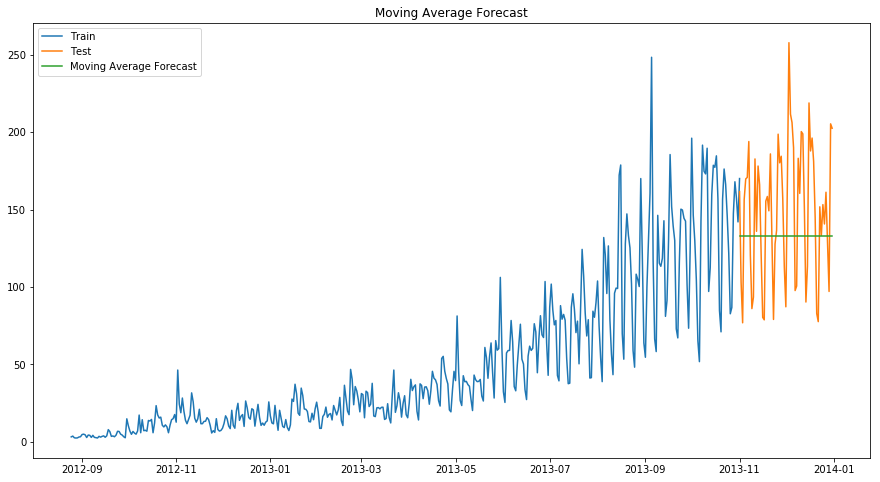

In [69]:
y_hat_avg = test.copy()
y_hat_avg['moving_average_forecast'] = train['Count'].rolling(60).mean().iloc[-1]
plt.figure(figsize = (15,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index, test['Count'], label='Test')
plt.plot(y_hat_avg.index, y_hat_avg['moving_average_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.title('Moving Average Forecast')

In [70]:
# We'll now calculate RMSE to check accuracy of Moving Average Method on our test dataset

rmse = np.sqrt(mean_squared_error(test.Count, y_hat_avg['moving_average_forecast']))
print(rmse)

46.30440916408297


We can see from the RMSE values for the last 3 methods that Moving Average Method outperforms Simple Average and Naive Method.

## Method 4 - Weighted Moving Average Method

An advancement over Moving average method is Weighted moving average method. In the Moving average method as seen above, we equally weigh the past ‘n’ observations. But we might encounter situations where each of the observation from the past ‘n’ impacts the forecast in a different way. Such a technique which weighs the past observations differently is called Weighted Moving Average technique.

A weighted moving average is a moving average where within the sliding window values are given different weights, typically so that more recent points matter more. Instead of selecting a window size, it requires a list of weights (which should add up to 1). For example if we pick [0.40, 0.25, 0.20, 0.15] as weights, we would be giving 40%, 25%, 20% and 15% to the last 4 points respectively.

Text(0.5, 1.0, 'Weighted Moving Average Forecast')

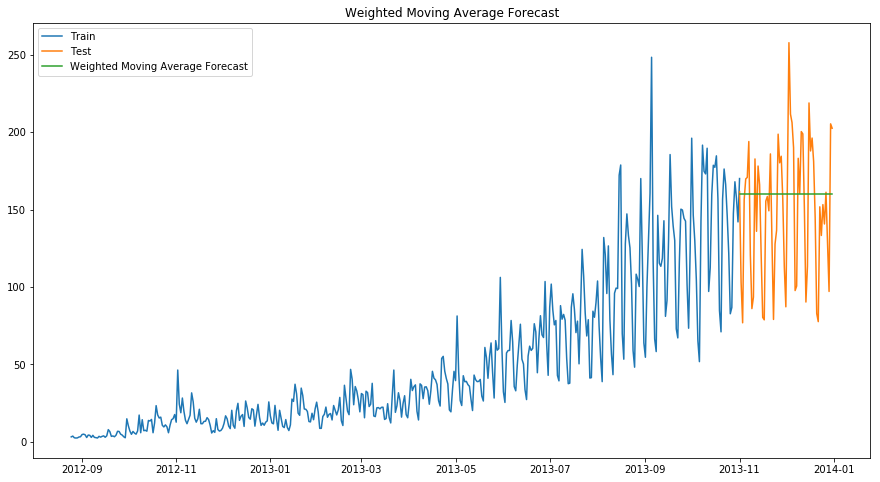

In [77]:
y_hat_avg = test.copy()
y_hat_avg['weighted_moving_average_forecast'] = 0.4*dd[-1] + 0.25*dd[-2] + 0.2*dd[-3] + 0.15*dd[-4]
plt.figure(figsize=(15,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index, test['Count'], label='Test')
plt.plot(y_hat_avg.index, y_hat_avg['weighted_moving_average_forecast'], label='Weighted Moving Average Forecast')
plt.legend(loc='best')
plt.title('Weighted Moving Average Forecast')

In [78]:
# We'll now calculate RMSE to check accuracy of Weighted Moving Average Method on our test dataset

rmse = np.sqrt(mean_squared_error(test.Count, y_hat_avg['weighted_moving_average_forecast']))
print(rmse)

44.6295999559093


Weighted Moving Average Method with weights [0.40, 0.25, 0.20, 0.15] outperforms all the previous forecasting methods.

We would further look at Simple Exponential Smoothing Method.

## Method 5 - Simple Exponential Smoothing Method

After we have understood the above methods, we can note that both Simple Average and Weighted Moving Average lie on completely opposite ends. 

We would need something between these two extreme approaches which takes into account all the data while weighing the data points differently. 

For example it may be sensible to attach larger weights to more recent observations than to observations from the distant past. The technique which works on this principle is called Simple Exponential Smoothing.

Forecasts are calculated using weighted averages where the weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations:

The one-step-ahead forecast for time T+1 is a weighted average of all the observations in the series y1,…,yT. The rate at which the weights decrease is controlled by the parameter α, where 0 ≤ α ≤ 1 is the smoothing parameter.

So essentially we’ve got a weighted moving average with two weights: α and 1−α.

As we can see, 1−α is multiplied by the previous expected value ŷ at t which makes the expression recursive. And this is why this method is called Exponential. 

The forecast for time t+1 is equal to a weighted average between the most recent observation y at t and the most recent forecast ŷ  for t.

In [79]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

Text(0.5, 1.0, 'Simple Exponential Smoothing Forecast')

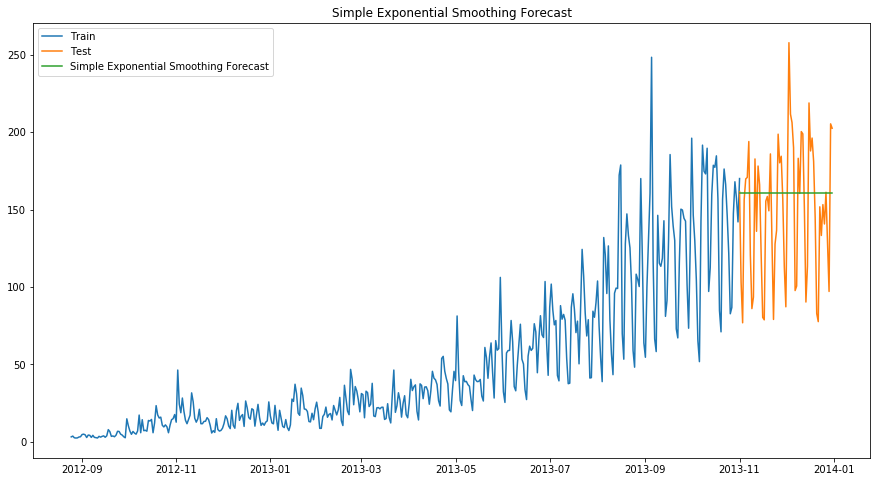

In [80]:
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(15,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index, test['Count'], label='Test')
plt.plot(y_hat_avg.index, y_hat_avg['SES'], label='Simple Exponential Smoothing Forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Forecast')

In [81]:
# We'll now calculate RMSE to check accuracy of SES Method on our test dataset

rmse = np.sqrt(mean_squared_error(test.Count, y_hat_avg['SES']))
print(rmse)

44.8056932656237


We see that implementing Simple Exponential Smoothing method with alpha as 0.6 generates a model as good as Weighted Moving Average Method if not better.

## Method 6 - Holt's Linear Trend Method

We have now learnt several methods to forecast but we can see that these models don’t work well on data with high variations.

If there had been a linearly increasing or decreasing trend in the data, all of the above methods wouldn't be able to take that into account.

Trend is the general pattern of data that we observe over a long period of time.

Although each one of the above methods can be applied to the trend as well.  E.g. the Naive method would assume that trend between last two points is going to stay the same, or we could average all slopes between all points to get an average trend, use a moving trend average or apply exponential smoothing.

But we need a method that can map the trend accurately without any assumptions. Such a method that takes into account the trend of the dataset is called Holt’s Linear Trend method.

Each Time series dataset can be decomposed into it’s componenets which are Trend, Seasonality and Residual. Any dataset that follows a trend can use Holt’s linear trend method for forecasting.

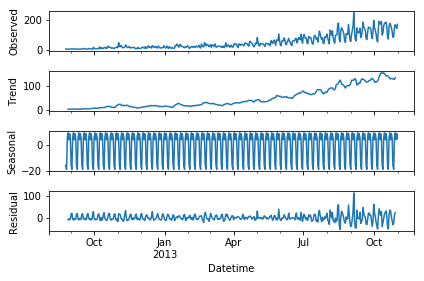

In [84]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(train['Count']).plot()
result = sm.tsa.stattools.adfuller(train['Count'])
plt.show()

We can see from the graphs obtained that this dataset follows an increasing trend. Hence we can use Holt’s linear trend to forecast the future prices.

Holt extended simple exponential smoothing to allow forecasting of data with a trend. It is nothing more than exponential smoothing applied to both level(the average value in the series) and trend.

To express this in mathematical notation we now need three equations: 
1. level 
2. trend 
3. Add level and trend to get the expected forecast ŷ

We can also generate a multiplicative forecast equation by multiplying trend and level instead of adding it. When the trend increases or decreases linearly, additive equation is used whereas when the trend increases of decreases exponentially, multiplicative equation is used.Practice shows that multiplicative is a more stable predictor, the additive method however is simpler to understand.

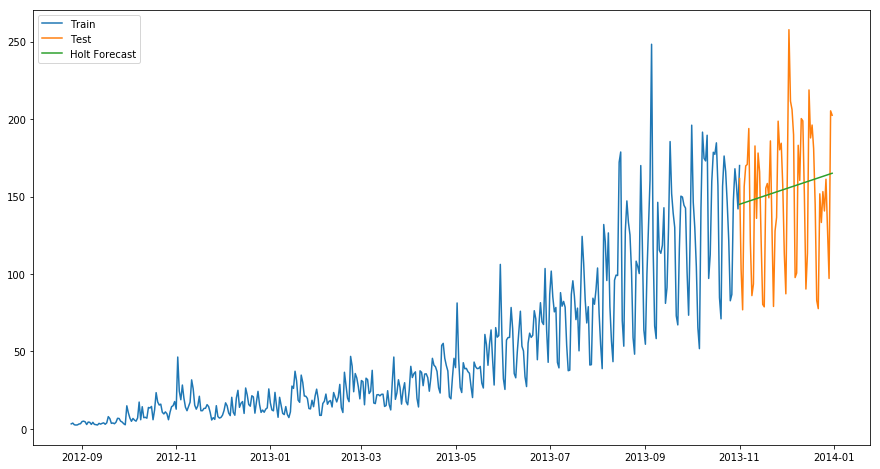

In [100]:
y_hat_avg = test.copy()
fit1 = Holt(np.asarray(train['Count'])).fit(smoothing_level=0.10, smoothing_slope=0.0005)
y_hat_avg['Holt'] = fit1.forecast(len(test))
plt.figure(figsize=(15,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index, test['Count'], label='Test')
plt.plot(y_hat_avg.index, y_hat_avg['Holt'], label='Holt Forecast')
plt.legend(loc='best')

In [101]:
# We'll now calculate RMSE to check accuracy of Holt Linear Trend Method on our test dataset

rmse = np.sqrt(mean_squared_error(test.Count, y_hat_avg['Holt']))
print(rmse)

43.229435291567555


Holts Linear Trend Method gives the best result so far. However, let's see some more methods.

## Method 7 - Holt's Winter Method

The above mentioned models don’t take into account the SEASONALITY of the dataset while forecasting. Hence we need a method that takes into account both trend and seasonality to forecast future prices.

The level equation shows a weighted average between the seasonally adjusted observation and the non-seasonal forecast for time t.

The trend equation is identical to Holt’s linear method. 

The seasonal equation shows a weighted average between the current seasonal index, and the seasonal index of the same season last year (i.e., s time periods ago).


In this method also, we can implement both additive and multiplicative technique.  The additive method is preferred when the seasonal variations are roughly constant through the series, while the multiplicative method is preferred when the seasonal variations are changing proportional to the level of the series.

Text(0.5, 1.0, "Holt's Winter Forecast")

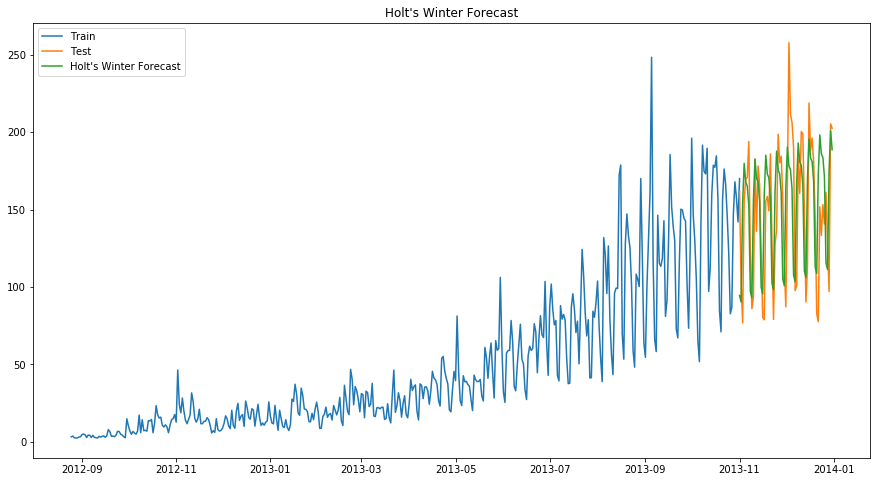

In [113]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Count']), seasonal_periods=7,trend='add', seasonal='add').fit()
y_hat_avg['Holt_Winter']= fit1.forecast(len(test))
plt.figure(figsize=(15,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index, test['Count'], label='Test')
plt.plot(y_hat_avg.index, y_hat_avg['Holt_Winter'],label="Holt's Winter Forecast")
plt.legend(loc='best')
plt.title("Holt's Winter Forecast")

In [115]:
# We'll now calculate RMSE to check accuracy of Holt's Winter Method on our test dataset

rmse = np.sqrt(mean_squared_error(test.Count, y_hat_avg.Holt_Winter))
print(rmse)

40.20077775399959


This is by far the BEST ACCURACY so far. 

## Method 8 - ARIMA (Autoregressive Integrated Moving Average)

While exponential smoothing models were based on a description of trend and seasonality in the data, ARIMA models aim to describe the correlations in the data with each other. An improvement over ARIMA is Seasonal ARIMA. It takes into account the seasonality of dataset just like Holt’ Winter method.

C:\Users\visha\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


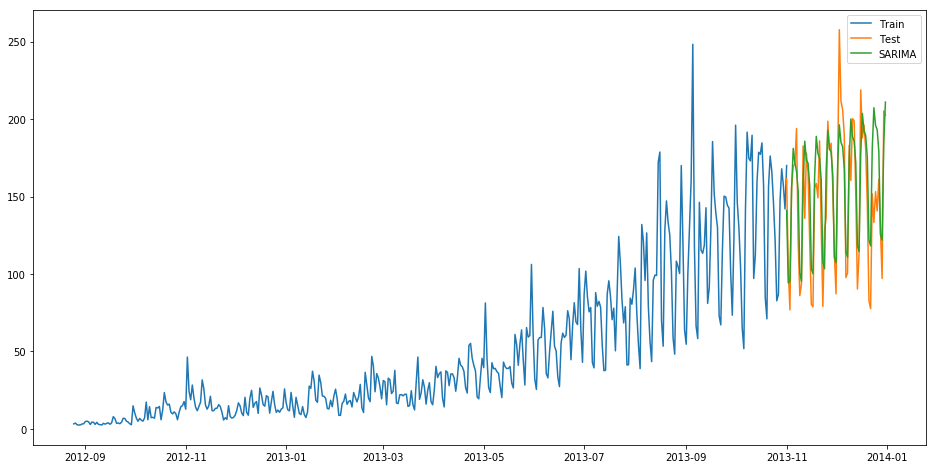

In [116]:
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train['Count'], order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2013-11-1", end="2013-12-31", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [117]:
# We'll now calculate RMSE to check accuracy of Holt's Winter Method on our test dataset

rmse = np.sqrt(mean_squared_error(test.Count, y_hat_avg.SARIMA))
print(rmse)

26.15714911397884


## WOW! This is by far the best result. SARIMA seem to have worked well here.